In [1]:
import numpy as np
import scipy.optimize as op
import datetime
import emcee
import matplotlib.pyplot as plt
import corner
from scipy.stats import norm, halfnorm
%matplotlib inline

In [2]:
mars = np.genfromtxt('harp_mars.dat', usecols=np.arange(0, 9))
jupiter = np.genfromtxt('harp_jupiter.dat', usecols=np.arange(0, 8))
uranus = np.genfromtxt('harp_uranus.dat', usecols=np.arange(0, 8))

In [3]:
mars_etamb = mars[:,5]
jupiter_etamb = jupiter[:,5]
uranus_etamb = uranus[:,5]

mars_dates = mars[:,0]
jupiter_dates = jupiter[:,0]
uranus_dates = uranus[:,0]

mars = mars[mars[:,1] > 5]
mars = mars[mars[:,1] < 19]
mars = mars[mars[:,5] > 0]
jupiter = jupiter[jupiter[:,1] > 5]
jupiter = jupiter[jupiter[:,1] < 19]
jupiter = jupiter[jupiter[:,5] > 0]
uranus = uranus[uranus[:,1] > 5]
uranus = uranus[uranus[:,1] < 19]
uranus = uranus[uranus[:,5] > 0]

planets_etamb = np.concatenate((mars_etamb, jupiter_etamb, uranus_etamb), axis=0)
raw_dates = np.concatenate((mars_dates, jupiter_dates, uranus_dates), axis=0)
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in raw_dates]

In [4]:
oldest = min(dates)
days = np.array([np.float64((date - oldest).days) + 1 for date in dates])

In [51]:
m_true = 0.0
b_true = .5

delty1_true = 0.0
delty2_true = 0.3
sigsq1_true = .01
sigsq2_true = .04
a1_true = .5
a2_true = .5

In [52]:
# adapted code from http://code.activestate.com/recipes/189971-basic-linear-algebra-matrix/
def minor(matrix, i, j):
    #input should be numpy matrix
    matrix = np.asarray(matrix)
    m = np.zeros((matrix.shape[0]-1, matrix.shape[1]-1))
    m = np.matrix(m)
    # loop through the matrix, skipping over the row and column specified by i and j
    minor_row = minor_col = 0
    for row in range(matrix.shape[0]):
        if not row == i: # skip row i
            for col in range(matrix.shape[1]):
                if not col == j: # skip column j
                    m[(minor_row, minor_col)] = matrix[(row, col)]
                    minor_col += 1
            minor_col = 0
            minor_row += 1
    return m

In [84]:
def lnlike(theta, x, y):
    m, b, delty1, delty2, sigsq1, sigsq2, a1 = theta
    a2 = 1.0 - a1
    #number in variable name is the gaussian j

    y_mod1 = m*x + b - delty1
    y_mod2 = m*x + b - delty2
    chisq1 = (1/sigsq1) * np.dot(y-y_mod1, y-y_mod1)
    chisq2 = (1/sigsq2) * np.dot(y-y_mod2, y-y_mod2)
    H = [np.exp(-chisq1/2), np.exp(-chisq2/2)]
    
    beta1 = -np.log(a1/np.sqrt(2*np.pi*sigsq1))
    beta2 = -np.log(a2/np.sqrt(2*np.pi*sigsq2))
    M = []
    for i in range(len(days)):
        if i == 0:
            temp_y = y[i+1:]
            temp_x = x[i+1:]
        else:
            temp_y = np.concatenate((y[:i],y[i+1:]))
            temp_x = np.concatenate((x[:i],x[i+1:]))
        temp_y_mod1 = m*temp_x + b - delty1
        temp_y_mod2 = m*temp_x + b - delty2
        minor_chisq1 = sigsq1 * np.dot(temp_y-temp_y_mod1, temp_y-temp_y_mod1)
        minor_chisq2 = sigsq2 * np.dot(temp_y-temp_y_mod2, temp_y-temp_y_mod2)
        M.append([np.exp(-.5*(beta1 - minor_chisq1)), np.exp(-.5*(beta2 - minor_chisq2))])
    
    MxH = np.matmul(np.matrix(M), np.matrix(H).T)
    return np.log(MxH).sum()

In [85]:
print(np.log(-1))

nan


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [86]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, delty1_true, delty2_true, sigsq1_true, sigsq2_true, a1_true], args=(days, planets_etamb))
m_ml, b_ml, delty1_ml, delty2_ml, sigsq1_ml, sigsq2_ml, a1_ml = result["x"]

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


In [87]:
print(m_ml, b_ml, delty1_ml, delty2_ml, sigsq1_ml, sigsq2_ml, a1_ml)

1034.16374197 1.13004939549 -0.630049643745 0.3 12.5375083051 0.04 0.500301879181


In [88]:
def lnprior(theta):
    m, b, delty1, delty2, sigsq1, sigsq2, a1 = theta
    if 0.0 < b < 1.0 and 0.0 < a1 < 1.0 and sigsq1 > 0.0 and sigsq2 > 0.0:
        pri_m = norm.logpdf(m, 0.0, 1.0)
        pri_delty1 = norm.logpdf(delty1, 0.0, 0.5)
        pri_delty2 = norm.logpdf(delty2, 0.3, 0.5)
        pri_sigsq1 = norm.logpdf(sigsq1, .01, .01)
        pri_sigsq2 = norm.logpdf(sigsq2, .04, .01)
        pri_a1 = halfnorm.logpdf(a1, 0.0, 1.0/3.0)
        return pri_m + pri_delty1 + pri_delty2 + pri_sigsq1 + pri_sigsq2 + pri_a1
    return -np.inf

In [89]:
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

In [90]:
ndim, nwalkers = 7, 200
# pos = [result["x"] + np.random.randn(ndim)*1e-4*[.2, .1, .5, .3, .3] for i in range(nwalkers)] #nwalkers x ndim entries
pos = [np.random.randn(ndim)*1e-4*[0.001, .6, 0.0, 0.3, .01, .04, .5] for i in range(nwalkers)]

In [91]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(days, planets_etamb), threads=4, a=2.0)

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log


In [92]:
sampler.run_mcmc(pos, 1000)

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[  2.51678982e-08,   5.10117265e-06,   0.00000000e+00, ...,
          -8.80863629e-07,  -1.14407183e-06,  -6.68098067e-05],
        [ -9.91950596e-08,   2.78910826e-05,   0.00000000e+00, ...,
          -9.38499354e-07,   2.18911248e-06,  -9.16326475e-05],
        [  4.69465600e-08,  -3.09993300e-05,   0.00000000e+00, ...,
          -2.22337847e-08,   7.27645890e-06,   4.49858493e-05],
        ..., 
        [ -7.69267302e-08,   9.12542553e-06,  -0.00000000e+00, ...,
           9.47835806e-07,   6.70337623e-07,   2.63364380e-05],
        [  2.23324739e-08,   4.04608188e-05,  -0.00000000e+00, ...,
           4.80448584e-07,  -2.45869978e-06,   1.00883760e-05],
        [  5.95471585e-08,  -3.44868055e-05,   0.00000000e+00, ...,
           1.45639485e-06,  -3.69573235e-06,  -8.65235577e-05]]),
 array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, 

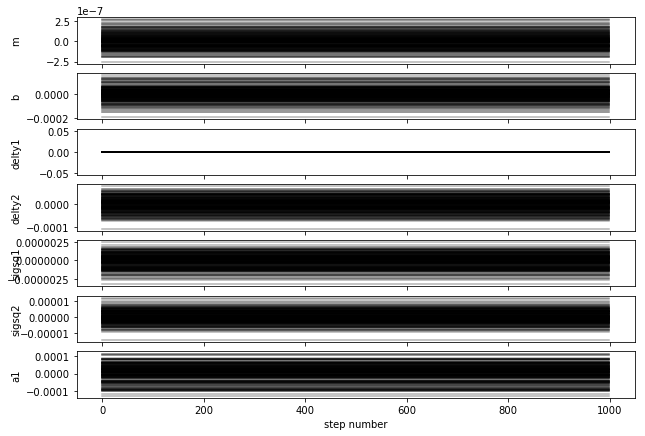

In [93]:
plt.figure(1)
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["m", "b", "delty1", "delty2", "sigsq1", "sigsq2", "a1"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
    #(nwalkers, nsteps, dim)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
fig.savefig("200walkers_smallinit_a2.0_1000steps_nongauss_noscatter_matrixeq22.png")
plt.show()

In [94]:
flat_samples = sampler.chain[:, 200:, :].reshape((-1, ndim))

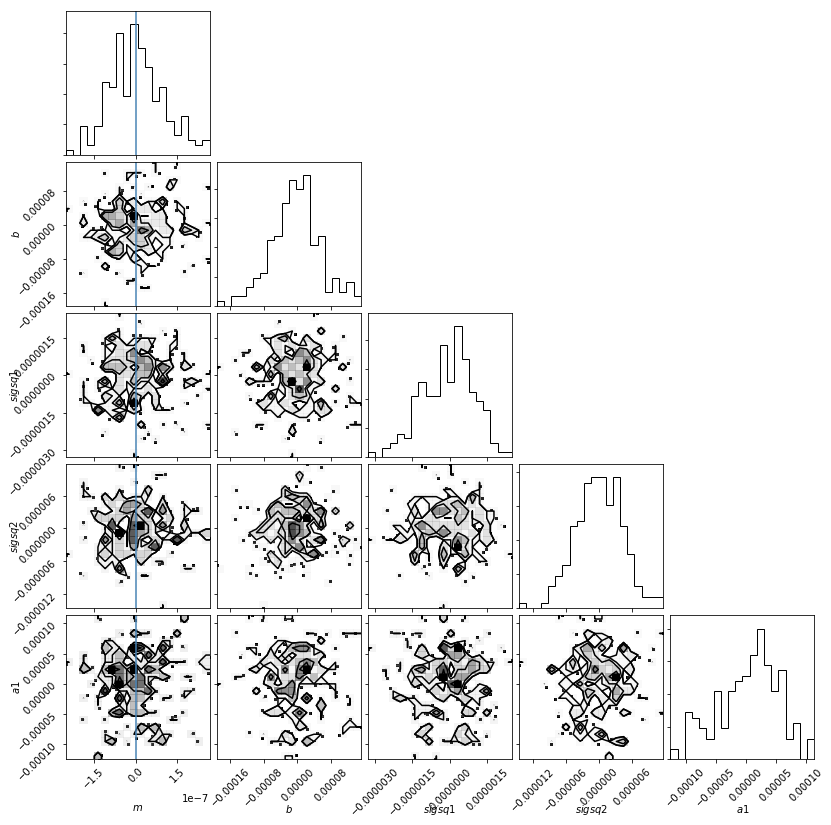

In [100]:
fig = corner.corner(flat_samples[:,[0,1,4,5,6]], labels=["$m$", "$b$", "$sigsq1$", "$sigsq2$", "$a1$"],
                      truths=[m_true, b_true, sigsq1_true, sigsq2_true, a1_true])
fig.savefig("200walkers_smallinit_a2.0_1000steps_nongauss_noscatter_corner_matrixeq22.png")

In [101]:
from IPython.display import display, Math
results = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    results.append(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>